<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Specify-All-Models" data-toc-modified-id="Specify-All-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Specify All Models</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Single-Split-Results" data-toc-modified-id="Single-Split-Results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Single Split Results</a></span></li><li><span><a href="#k=10-CV-Results" data-toc-modified-id="k=10-CV-Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>k=10 CV Results</a></span></li><li><span><a href="#Visualisation-of-Results" data-toc-modified-id="Visualisation-of-Results-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualisation of Results</a></span></li></ul></li><li><span><a href="#Optimising-Hyperparameters" data-toc-modified-id="Optimising-Hyperparameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimising Hyperparameters</a></span><ul class="toc-item"><li><span><a href="#Split-Models-into-3-Groups" data-toc-modified-id="Split-Models-into-3-Groups-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Split Models into 3 Groups</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Model-Group-Parameter-Dictionary" data-toc-modified-id="Model-Group-Parameter-Dictionary-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Model Group Parameter Dictionary</a></span></li></ul></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance</a></span></li></ul></div>

In [43]:
import pandas as pd
import numpy as np
import math
from scipy import stats


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', 500)

In [5]:
data_path = "../data"
file = "train"

df = pd.read_csv("{}/{}_final.csv".format(data_path, file))
label = pd.read_csv("{}/label_final.csv".format(data_path), 
                    header=None, names=["SalePrice_log"])
df.head()

,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,TotalSF,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.320894,-0.267660,3,3,3,2,7,5,0.652174,0.243243,1.034410,3,2,4,3,1,6,0.092710,1,0.0,-0.898157,-0.300181,4,4,-0.524119,1.024186,0.0,0.342891,1.0,0.000000,0.0,1.0,0.0,0.0,3,1.0,7,-1.0,0,0.589744,2,0.0,0.281573,3,

### Specify All Models

In [6]:
seed = 88

linear_models = {
    'linear': LinearRegression(n_jobs = -1),
    'lasso': Lasso(random_state = seed),
    'ridge': Ridge(random_state = seed),
    'kr': KernelRidge(),
    'elnt': ElasticNet(random_state = seed),
    'dt': DecisionTreeRegressor(random_state = seed),
    'svm': SVR(),
    'knn': KNeighborsRegressor(n_jobs = -1),
    'rf':  RandomForestRegressor(n_jobs = -1, random_state = seed),
    'et': ExtraTreesRegressor(n_jobs = -1, random_state = seed),
    'ab': AdaBoostRegressor(random_state = seed),
    'gb': GradientBoostingRegressor(random_state = seed),
    'xgb': XGBRegressor(random_state = seed, n_jobs = -1)
#     'lgb': LGBMRegressor(random_state = seed, n_jobs = -1)
}

In [7]:
seed = 888
X = df
y = label

### Model Training

We first train with a single train-test split and then do a k=10 CV.

In [8]:
label.head()

,SalePrice_log
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216


#### Functions

In [9]:
# def train_model_r_sq(model, X, y):
#     X_train, X_test, y_train, y_test = train_test_split(
#                                             X, y, test_size=0.3,
#                                             random_state=seed
#                                         )
#     model.fit(X_train, y_train)
#     return 

def train_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
                                            X, y, test_size=0.3,
                                            random_state=seed
                                        )
    model.fit(X_train, y_train)
    return np.sqrt(mean_squared_error(model.predict(X_test), y_test)), model.score(X_train, y_train)

def display_single_split_results(model_group, X, y):
    dp = 3
    results = []
    for name, model in model_group.items():
        rmse, r_sq = train_model(model, X, y)
        results.append(
            (name, round(rmse, dp), round(r_sq*100, dp))
        )
    
    # Unzip and then tranpose to create the columns. 
    tuple_arr = [list(x) for x in zip(*results)]
    return pd.DataFrame(np.transpose(tuple_arr), columns=["model", "rmse", "r_sq"])

def cross_validate_model(model, X, y, cv):
    dp=3
    neg_mse = cross_val_score(model, X, y, 
                                      cv=cv, n_jobs=-1, 
                                      scoring = 'neg_mean_squared_error'
                                     )
    x_val_score = np.round(np.sqrt(-1*neg_mse), dp)
    return x_val_score.mean()

def display_cv_results(model_group, X, y, cv):
    dp = 3
    results = []
    for name, model in model_group.items():
        cv_rmse = cross_validate_model(model, X, y, cv)
        results.append(
            (name, round(cv_rmse, dp))
        )
    
    # Unzip and then tranpose to create the columns. 
    tuple_arr = [list(x) for x in zip(*results)]
    return pd.DataFrame(np.transpose(tuple_arr), columns=["model", "cv_rmse"]) 

`np.sqrt` handles np.arrays only so if you pass in a single element it will return an empty array. 

#### Single Split Results

In [10]:
results_df = display_single_split_results(linear_models, X, y)
results_df.sort_values("rmse")

[16:07:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model,rmse,r_sq
6,svm,0.143,94.402
12,xgb,0.149,96.069
2,ridge,0.151,94.776
11,gb,0.151,97.054
9,et,0.165,100.0
8,rf,0.167,97.543
10,ab,0.176,86.803
7,knn,0.194,86.945
5,dt,0.226,100.0
3,kr,0.25,94.404


In [11]:
results_df["rmse"] = results_df["rmse"].astype(float)
results_df["r_sq"] = results_df["r_sq"].astype(float)

In [12]:
results_df[~results_df["model"].isin(["linear"])]["model"]

1     lasso
2     ridge
3        kr
4      elnt
5        dt
6       svm
7       knn
8        rf
9        et
10       ab
11       gb
12      xgb
Name: model, dtype: object

For more aesthetic configurations check it out [here](https://seaborn.pydata.org/tutorial/aesthetics.html)

#### k=10 CV Results

In [13]:
results_cv = display_cv_results(linear_models, X, y, cv=10)
results_cv["cv_rmse"] = results_cv["cv_rmse"].astype(float)
results_cv

,model,cv_rmse
0,linear,7.602510e+09
1,lasso,3.990000e-01
2,ridge,1.260000e-01
3,kr,1.620000e-01
4,elnt,3.990000e-01
5,dt,1.970000e-01
6,svm,1.230000e-01
7,knn,1.810000e-01
8,rf,1.490000e-01
9,et,1.480000e-01


#### Visualisation of Results

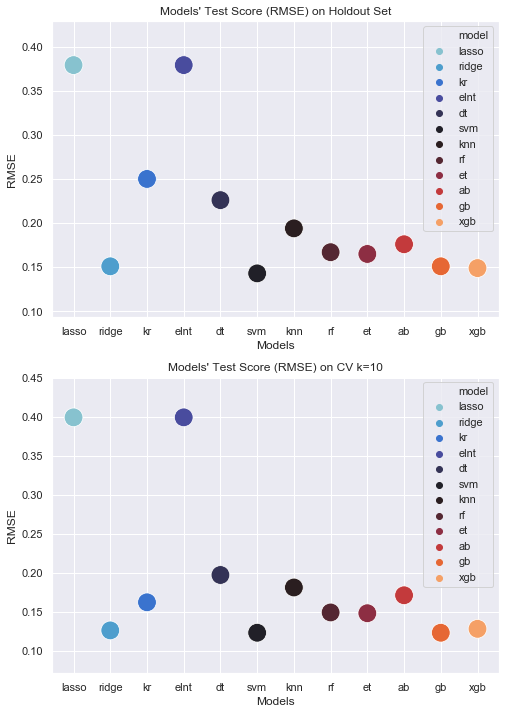

In [15]:
num_cols = 1

fig, axes = plt.subplots(2, num_cols)
fig.set_figheight(12)
fig.set_figwidth(8)
fig.subplots_adjust(hspace=0.2, wspace=0.5)

sns.set()
# sns.set_style("ticks")
# sns.axes_style("darkgrid")

title = "Models' Test Score (RMSE) on Holdout Set"
models_except_ols = results_df[~results_df["model"].isin(["linear"])]["model"]
sns.scatterplot(models_except_ols, 
                results_df["rmse"], palette='icefire', 
                hue=models_except_ols, s=350, 
                ax=axes[0]).set(
    xlabel="Models",
    ylabel="RMSE",
    title=title
)
# plt.xticks(rotation=90)
# plt.legend(loc=(1.02, 0.03))

title = "Models' Test Score (RMSE) on CV k=10"
models_except_ols = results_cv[~results_cv["model"].isin(["linear"])]["model"]
sns.scatterplot(models_except_ols, 
                results_cv["cv_rmse"], palette='icefire', 
                hue=models_except_ols, s=350,
                ax=axes[1]).set(
    xlabel="Models",
    ylabel="RMSE",
    title=title
)
# plt.xticks(rotation=90)
# plt.legend(loc=(1.02, 0.03))

plt.show()

### Optimising Hyperparameters

We carefully construct a parameter space for each regression model, and then utilise `GridSearchCV` or `RandomSearchCV` to explore the sapce to find the optimal choices.

Since we don't really know what the optimal range of parameters are necessary, we will conduct a more broader search and then do a secondary search once we have narrowed down the parameter range. 

In [64]:
np.asarray(y).flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

#### Split Models into 3 Groups

In [79]:
linear_models = {
    'lasso': Lasso(random_state = seed),
    'ridge': Ridge(random_state = seed),
    'elnt': ElasticNet(random_state = seed)
}

tree_boost_models = {
    'rf':  RandomForestRegressor(n_jobs = -1),
    'et': ExtraTreesRegressor(n_jobs = -1),
    'ab': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'xgb': XGBRegressor(n_jobs = -1)
#   'lgb': LGBMRegressor(n_jobs = -1)
}

other_models = {
    'dt': DecisionTreeRegressor(),
    'svm': SVR(),
    'knn': KNeighborsRegressor(n_jobs = -1),
    'kr': KernelRidge()
}

#### Functions

In [80]:
def grid_search_model(model, model_params, X, y, cv):
    grid_search = GridSearchCV(estimator = model, param_grid = model_params, 
                               cv = cv, verbose = 1,
                               scoring = 'neg_mean_squared_error', 
                               n_jobs = -1
                            )
    grid_search.fit(X, y)
    best_params = grid_search.best_params_ 
    best_score = math.sqrt(-1*(grid_search.best_score_))
    return best_params, best_score

def random_search_model(model, model_params, X, y, cv):
    grid_search = RandomizedSearchCV(
                    estimator = model, 
                    n_iter = 20, 
                    param_distributions = model_params, 
                    cv = cv, verbose = 1,
                    scoring = 'neg_mean_squared_error', 
                    n_jobs = -1
                )
    print("Fitting X & y")
    print("y.flags: {}".format(y.flags))
    print("X.flags: {}".format(X.flags))
    grid_search.fit(X, y)
    best_params = grid_search.best_params_ 
    print(grid_search.best_params_, grid_search.best_score_)
    best_score = math.sqrt(-1*(grid_search.best_score_))
    print(best_params, best_score)
    return best_params, best_score

def display_tuning_results(model_group, model_group_params, 
                           X, y, cv):
    """
    
    Parameters
    ----------
    model_group: Group of models stored in a dict 
                 {
                    'xgb': XGBRegressor(...),
                    ...,
                    'ridge': Ridge(...)
                    
                 }
    params: Parameters stored in defaultdict(dict)
            {
                'xgb': {
                    'learning_rate': [1, 0.5, ...]
                    'n_estimators': [1, 2, 4, ...]
                    ....,
                    'min_samples_leaf': [0.1, 0.5, 1, ...]
                },
                ...,
                'ridge':{
                    'alpha': [9, 9.2, ..., 9.8]
                    ...,
                    'random_state': [40]
                }
            }
    X: DataFrame of training data
    y: pandas series of testing data
    cv: number of folds
    
    Returns
    -------
    DataFrame of results recording the best parameters and the score
    corresponding to those parameters. 
    
    """
    dp = 3
    results = []
    for name, model in model_group.items():
        # We use RandomizedSearchCV
        best_param, cv_rmse = random_search_model(
                                model, 
                                model_group_params[name],
                                X, y, cv
                            )
        print("now rounding")
        results.append(
            (name, best_param, round(cv_rmse, dp))
        )
    
    # Unzip and then tranpose to create the columns. 
    tuple_arr = [list(x) for x in zip(*results)]
    print()
    return pd.DataFrame(
        np.transpose(tuple_arr), 
        columns=["model", "opt_params", "cv_rmse"]
    ) 

#### Model Group Parameter Dictionary

XGboost's sklearn wrapper can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [81]:
seed = 88

model_group_params_dict_broad = {
    'lasso': {
        'alpha': [
            0.001, 0.002, 0.005, 0.01, 0.02, 
            0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
            0.09, 0.1, 0.2, 0.5, 0.8, 1
        ],
        'tol': [
            0.00001, 0.0001, 0.01,
            0.00002, 0.0002, 0.02,
            0.00003, 0.0003, 0.03,
            0.00004, 0.0004, 0.04,
            0.00005, 0.0005, 0.05,
        ],
        'selection': ['random', 'cyclic'],
        'random_state': [seed],
    },
    'ridge': {
#         'alpha': [
#             9, 9.2, 9.4, 9.5, 9.52, 
#             9.56, 9.6, 9.64, 9.68, 
#             9.7, 9.8, 9.85, 9.9,
#         ],
        'alpha': [
            1, 3, 5, 7, 10,
            11, 13, 15, 17, 20,
            21, 23, 25, 27, 30
        ],
        'tol': [
            0.00001, 0.0001, 0.01,
            0.00002, 0.0002, 0.02,
            0.00003, 0.0003, 0.03
        ],
        'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
        'random_state': [seed]
    },
    'kr': {
        'alpha': [
            0.05, 0.1, 0.15, 0.2,
            0.25, 0.3, 0.35, 0.4, 
            0.45, 0.5, 0.55, 0.6,
            0.65, 0.7, 0.75, 0.8, 
            0.85, 0.9, 0.95, 1.0
        ],
        'gamma': [
            0.001, 0.005, 0.008,
            0.01, 0.05, 0.08,
            0.1, 0.5, 0.8
        ],
        'kernel': ['rbf', 'polynomial', 'linear', 'sigmoid'],
        'degree': [2, 3, 4],
        'coef0': [
            1, 1.5, 2, 2.5, 
            3, 3.5, 4, 4.5, 
            5, 5.5, 6, 6.5
        ]
    },
    'elnt': {
        'alpha': [
            0.001, 0.002, 0.005, 0.01, 0.02, 
            0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
            0.09, 0.1, 0.2, 0.5, 0.8, 1
        ],
        'l1_ratio': [
            0.05, 0.1, 0.15, 0.2, 
            0.25, 0.3, 0.35, 0.4, 
            0.45, 0.5, 0.55, 0.6, 
            0.65, 0.7, 0.75, 0.8, 
            0.85, 0.9, 0.95
        ],
        'tol': [
            0.00001, 0.0001, 0.01,
            0.00002, 0.0002, 0.02,
            0.00003, 0.0003, 0.03,
            0.00004, 0.0004, 0.04,
            0.00005, 0.0005, 0.05,
        ],
        'selection': ['random', 'cyclic'],
        'random_state': [seed]
    },
    'dt': {
        'splitter': ['best', 'random'],
        'max_depth': [
            3, 4, 5, 6, 7, 8
        ],
        'min_samples_split': [
            2, 3, 4, 5, 6, 7,
            8, 9, 10, 11, 12, 13
        ],
        'min_samples_leaf': [
            1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10
        ],
        'max_features': [
            5, 8, 11, 14, 17,
            20, 23, 26, 29, 32,
            'auto', 'sqrt', 'log2'
        ],
        'random_state': [seed]
    },
    'svm': {
        'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
        'degree': [2, 3, 4, 5],
        'gamma': [
            0.0001, 0.001, 0.1,
            0.0002, 0.002, 0.2,
            0.0003, 0.003, 0.3,
            0.0004, 0.004, 0.4,
            0.0005, 0.005, 0.5,
        ],
        'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'epsilon': [
            0.001, 0.01, 0.1, 
            0.005, 0.05, 0.5, 
            0.008, 0.08, 0.8, 
        ]
    },
    'knn': {
        'n_neighbors': [
            1, 3, 5, 7, 9,
            11, 13, 15, 17, 19,
            21, 23, 25, 27, 29
        ],
        'algorithm': [
            'ball_tree', 'kd_tree'
        ],
        'leaf_size': [
            10, 15, 20, 25, 
            30, 35, 40, 45
        ]
    },
    'rf': {
        'bootstrap': [True, False],
        'n_estimators': [
            4, 8, 16, 32, 64, 128, 
            150, 200, 250, 300
        ],
        'max_depth': [
            3, 4, 5, 6, 7, 8
        ],
        'min_samples_split': [
            2, 3, 4, 5, 6, 7,
            8, 9, 10, 11, 12, 13
        ],
        'min_samples_leaf': [
            1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10
        ],
        'max_features': [
            5, 8, 11, 14, 17,
            20, 23, 26, 29, 32,
            'auto', 'sqrt', 'log2'
        ],
        'random_state': [seed],
    },
    'et': {
        'bootstrap': [True, False],
        'n_estimators': [
            4, 8, 16, 32, 64, 128, 
            150, 200, 250, 300
        ],
        'max_depth': [
            3, 4, 5, 6, 7, 8
        ],
        'n_estimators': [
            4, 8, 16, 32, 64, 128, 
            150, 200, 250, 300
        ],
        'min_samples_split': [
            2, 3, 4, 5, 6, 7,
            8, 9, 10, 11, 12, 13
        ],
        'min_samples_leaf': [
            1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10
        ],
        'max_features': [
            5, 8, 11, 14, 17,
            20, 23, 26, 29, 32,
            'auto', 'sqrt', 'log2'
        ],
        'random_state': [seed],
    },
    'ab': {
        'learning_rate': [
            0.01, 0.02, 0.05, 0.08,
            0.1, 0.2, 0.5, 0.8, 1,
            1.2, 1.5
        ],
        'loss': ['linear', 'square', 'exponential'],
        'random_state': [seed]
    },
    'gb': {
        'bootstrap': [True, False],
        'learning_rate': [
            0.01, 0.015, 0.02, 0.03,
            0.04, 0.05, 0.075, 0.085,
            0.1, 0.2, 0.5, 0.8, 1,
            1.2, 1.5
        ],
        'n_estimators': [
            4, 8, 16, 32, 64, 128, 
            150, 200, 250, 300
        ],
        'max_depth': [
            3, 4, 5, 6, 7, 8
        ],
        'min_samples_split': [
            2, 3, 4, 5, 6, 7,
            8, 9, 10, 11, 12, 13
        ],
        'min_samples_leaf': [
            1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10
        ],
        'max_features': [
            2, 4, 6, 8, 10, 12,
            15, 20, 25, 30, 35, 40,
            45, 50, 55, 60, 65, 70
        ],
        'random_state': [seed]
    },
    'xgb': {
        # typically gbtree performs better.
        'booster': ['gblinear', 'gbtree', 'dart'],
        'learning_rate': [
            0.05, 0.1, 0.15, 0.2, 
            0.25, 0.3, 0.35, 0.4,
            0.45, 0.5, 0.55, 0.6
        ],
        'n_estimators': [
            4, 8, 16, 32, 64, 128, 
            150, 200, 250, 300
        ],
        'max_depth': [
            3, 4, 5, 6, 7, 8
        ],
        'min_child_weight': [
            0.2, 0.4, 0.6, 0.8, 
            1, 1.2, 1.4, 1.6, 1.8,
            2, 5, 10, 15, 20
        ],
        'subsample': [
            0.3, 0.35, 0.4, 0.45,
            0.5, 0.55, 0.6, 0.65,
            0.7, 0.75, 0.8, 0.85,
            0.9, 0.95
        ],
        'colsample_bytree': [
            0.3, 0.35, 0.4, 0.45,
            0.5, 0.55, 0.6, 0.65,
            0.7, 0.75, 0.8, 0.85,
            0.9, 0.95
        ],
        # L1 reg
        'reg_alpha': [
            0.1, 0.2, 0.3, 0.4, 
            0.5, 0.6, 0.7, 0.8,  
            0.9, 1.0
        ],
        # L2 reg
        'reg_lambda': [
            0.5, 1, 1.5, 2,
            2.5, 3, 3.5, 4,
            5, 6, 7, 8, 10
        ],
        'random_state': [seed]
    }
#     'lgb': LGBMRegressor(random_state = seed, n_jobs = -1)
}

In [82]:
display_tuning_results(
    linear_models, model_group_params_dict_broad,
    np.asmatrix(X), np.asarray(y), cv=10
)

Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'tol': 0.0004, 'selection': 'random', 'random_state': 88, 'alpha': 0.001} -0.01556151184099973
{'tol': 0.0004, 'selection': 'random', 'random_state': 88, 'alpha': 0.001} 0.12474578887080609
now rounding
Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'tol': 0.0001, 'solver': 'svd', 'random_state': 88, 'alpha': 10} -0.01592282492695735
{'tol': 0.0001, 'solver': 'svd', 'random_state': 88, 'alpha': 10} 0.12618567639378628
now rounding
Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.6s


{'tol': 5e-05, 'selection': 'cyclic', 'random_state': 88, 'l1_ratio': 0.3, 'alpha': 0.002} -0.015456625189959935
{'tol': 5e-05, 'selection': 'cyclic', 'random_state': 88, 'l1_ratio': 0.3, 'alpha': 0.002} 0.12432467651258915
now rounding



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.2s finished


,model,opt_params,cv_rmse
0,lasso,"{'tol': 0.0004, 'selection': 'random', 'random...",0.125
1,ridge,"{'tol': 0.0001, 'solver': 'svd', 'random_state...",0.126
2,elnt,"{'tol': 5e-05, 'selection': 'cyclic', 'random_...",0.124


In [78]:
np.asmatrix(X).flags["C_CONTIGUOUS"]

False

In [83]:
display_tuning_results(
    other_models, model_group_params_dict_broad,
    np.asmatrix(X), np.asarray(y), cv=10
)

Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'splitter': 'random', 'random_state': 88, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 6} -0.03840636768101961
{'splitter': 'random', 'random_state': 88, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 6} 0.19597542621721636
now rounding
Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.7min finished


{'kernel': 'rbf', 'gamma': 0.0005, 'epsilon': 0.001, 'degree': 3, 'C': 6} -0.015527278034678163
{'kernel': 'rbf', 'gamma': 0.0005, 'epsilon': 0.001, 'degree': 3, 'C': 6} 0.124608499046727
now rounding
Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': 7, 'leaf_size': 15, 'algorithm': 'ball_tree'} -0.032474511949464414
{'n_neighbors': 7, 'leaf_size': 15, 'algorithm': 'ball_tree'} 0.18020685877475479
now rounding
Fitting X & y
y.flags:   C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
X.flags:   C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.0s


{'kernel': 'polynomial', 'gamma': 0.001, 'degree': 3, 'coef0': 2, 'alpha': 0.2} -0.015355615116767602
{'kernel': 'polynomial', 'gamma': 0.001, 'degree': 3, 'coef0': 2, 'alpha': 0.2} 0.12391777562871116
now rounding



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.4s finished


,model,opt_params,cv_rmse
0,dt,"{'splitter': 'random', 'random_state': 88, 'mi...",0.196
1,svm,"{'kernel': 'rbf', 'gamma': 0.0005, 'epsilon': ...",0.125
2,knn,"{'n_neighbors': 7, 'leaf_size': 15, 'algorithm...",0.18
3,kr,"{'kernel': 'polynomial', 'gamma': 0.001, 'degr...",0.124


### Feature Importance